## Importing Libraries

In [1]:
import nltk
import string
import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Disable Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Load Data

In [3]:
df_sms = pd.read_csv("msg_spam.csv", encoding="latin-1")

In [4]:
df_sms

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## Data Statistics

In [5]:
df_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df_sms.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [7]:
df_sms.isna().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of          v1     v2  Unnamed: 2  Unnamed: 3  Unnamed: 4
0     False  False        True        True        True
1     False  False        True        True        True
2     False  False        True        True        True
3     False  False        True        True        True
4     False  False        True        True        True
...     ...    ...         ...         ...         ...
5567  False  False        True        True        True
5568  False  False        True        True        True
5569  False  False        True        True        True
5570  False  False        True        True        True
5571  False  False        True        True        True

[5572 rows x 5 columns]>

In [8]:
df_sms.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [9]:
df_sms = df_sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df_sms = df_sms.rename(columns={"v1":"label", "v2":"sms"})
df_sms.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Checking the maximum length of SMS

In [10]:
print(len(df_sms))

5572


In [11]:
df_sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [12]:
df_sms.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [13]:
df_sms['length'] = df_sms['sms'].apply(len)
df_sms.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## EDA

<Axes: ylabel='Frequency'>

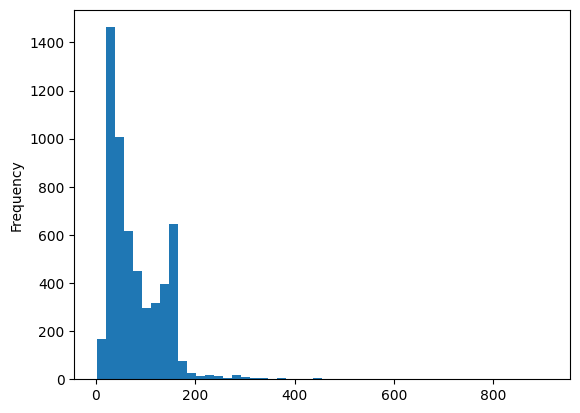

In [14]:
df_sms['length'].plot(bins=50, kind='hist')

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

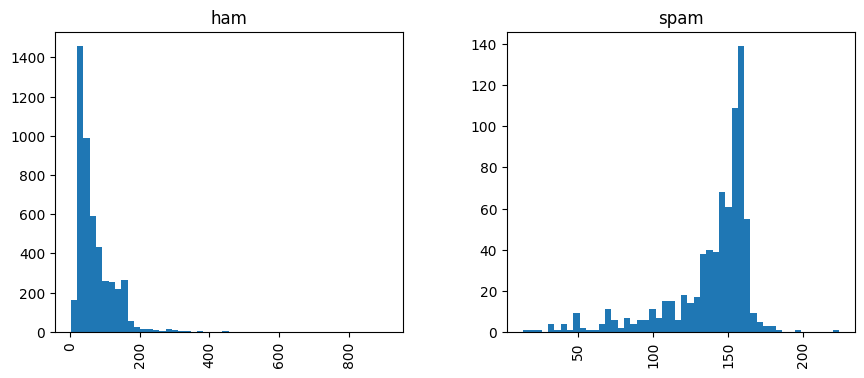

In [15]:
df_sms.hist(column='length', by='label', bins=50,figsize=(10,4))

In [16]:
df_sms.loc[:,'label'] = df_sms.label.map({'ham':0, 'spam':1})
print(df_sms.shape)
df_sms.head()

(5572, 3)


,label,sms,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


## Bag of Words Approach

### Implementation of Bag of Words Approach

#### Step 1: Convert all strings to their lower case form.

In [17]:
documents = ['Hello, how are you!',
             'Win money, win from home.',
             'Call me now.',
             'Hello, Call hello you tomorrow?']

lower_case_documents = []
lower_case_documents = [d.lower() for d in documents]
print(lower_case_documents)

['hello, how are you!', 'win money, win from home.', 'call me now.', 'hello, call hello you tomorrow?']


#### Step 2: Removing all punctuations

In [18]:
sans_punctuation_documents = []

for i in lower_case_documents:
    sans_punctuation_documents.append(i.translate(str.maketrans("","", string.punctuation)))
    
sans_punctuation_documents

['hello how are you',
 'win money win from home',
 'call me now',
 'hello call hello you tomorrow']

#### Step 3: Tokenization

In [19]:
preprocessed_documents = [[w for w in d.split()] for d in sans_punctuation_documents]
preprocessed_documents

[['hello', 'how', 'are', 'you'],
 ['win', 'money', 'win', 'from', 'home'],
 ['call', 'me', 'now'],
 ['hello', 'call', 'hello', 'you', 'tomorrow']]

#### Step 4: Count frequencies

In [20]:
frequency_list = []

frequency_list = [Counter(d) for d in preprocessed_documents]
pprint.pprint(frequency_list)

[Counter({'hello': 1, 'how': 1, 'are': 1, 'you': 1}),
 Counter({'win': 2, 'money': 1, 'from': 1, 'home': 1}),
 Counter({'call': 1, 'me': 1, 'now': 1}),
 Counter({'hello': 2, 'call': 1, 'you': 1, 'tomorrow': 1})]


### Implementing Bag of Words in scikit-learn

In [21]:
count_vector = CountVectorizer()

#### Data Preprocessing

In [22]:
count_vector.fit(documents)
count_vector.get_feature_names_out()

array(['are', 'call', 'from', 'hello', 'home', 'how', 'me', 'money',
       'now', 'tomorrow', 'win', 'you'], dtype=object)

In [23]:
doc_array = count_vector.transform(documents).toarray()
doc_array

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1]])

In [24]:
frequency_matrix = pd.DataFrame(doc_array, columns = count_vector.get_feature_names_out())
frequency_matrix

,are,call,from,hello,home,how,me,money,now,tomorrow,win,you
0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,2,0
2,0,1,0,0,0,0,1,0,1,0,0,0
3,0,1,0,2,0,0,0,0,0,1,0,1


In [25]:
x = df_sms['sms']
y = df_sms["label"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.20, 
                                                    random_state=1)

In [27]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(X_test)

## Implementation of Naive Bayes

In [28]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

MultinomialNB()

In [29]:
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB()

In [30]:
predictions = naive_bayes.predict(testing_data)

## Evaluating our SMS Spam Detection Model

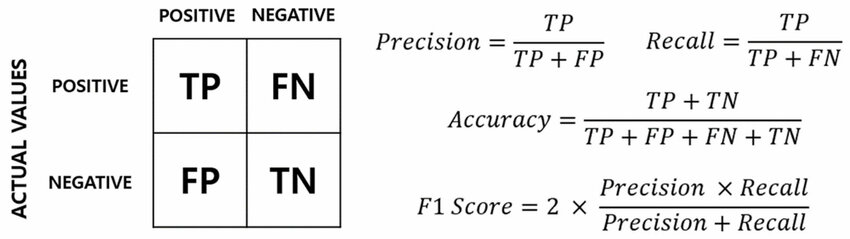

In [31]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {}'.format(precision_score(y_test, predictions)))
print('Recall score: {}'.format(recall_score(y_test, predictions)))
print('F1 score: {}'.format(f1_score(y_test, predictions)))

Accuracy score: 0.9847533632286996
Precision score: 0.9420289855072463
Recall score: 0.935251798561151
F1 score: 0.9386281588447652
